In [129]:
import numpy as np
import pandas as pd
import xgboost as xgb
import operator
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Imputer, OneHotEncoder
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [130]:
data = pd.read_csv('train.txt', usecols=range(1, 15), names=('x{}'.format(i) for i in range(14)), skiprows=1)
test = pd.read_csv('test.txt', usecols=range(1, 15), names=('x{}'.format(i) for i in range(14)), skiprows=1)
labels = pd.read_csv('target_train.txt')
labels = labels[1:]
labels = np.array(labels['target'])

In [157]:
print (enumerate(np.array(data.head(1))[0]))
text_feature_indexs = []
for index, value in enumerate(np.array(data.head(1))[0]):
    if not np.isreal(value):
        text_feature_indexs.append(index)
        
print (text_feature_indexs)

[1, 3, 5, 6, 7, 8, 9, 13]


In [132]:
test.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
0,28,Private,37821,Assoc-voc,11,Never-married,Sales,Unmarried,White,Female,0,0,55,?
1,45,Private,228570,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,35,United-States
2,21,Private,141453,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,40,United-States
3,34,Private,88215,Masters,14,Married-civ-spouse,Prof-specialty,Wife,Asian-Pac-Islander,Female,0,0,40,China
4,53,Private,48641,12th,8,Never-married,Other-service,Not-in-family,Other,Female,0,0,35,United-States


In [133]:
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [134]:
common_data = data
common_data = common_data.append(test)

In [135]:
def categorial_string_to_numbers(values):
    uniq_values = set(values)
    values_to_num = dict(zip(values, range(len(values))[::-1]))
    return map(lambda x: values_to_num[x], values)

In [136]:
for i in text_feature_indexs:
    common_data['x{}'.format(i)] = list(categorial_string_to_numbers(common_data['x{}'.format(i)]))

In [137]:
pd.DataFrame(common_data)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
0,39,11,77516,22,13,1,1,5,0,1,2174,0,40,0
1,50,10,83311,22,13,0,0,3,0,1,0,0,13,0
2,38,1,215646,0,9,11,9,5,0,1,0,0,40,0
3,53,1,234721,38,7,0,9,3,19,1,0,0,40,0
4,28,1,338409,22,13,0,12,0,19,0,0,0,40,653
5,37,1,284582,6,14,0,0,0,0,0,0,0,40,0
6,49,1,160187,59,5,104,16,5,19,0,0,0,16,331
7,52,10,209642,0,9,0,0,3,0,1,0,0,45,0
8,31,1,45781,6,14,1,12,5,0,0,14084,0,50,0
9,42,1,159449,22,13,0,0,3,0,1,5178,0,40,0


In [138]:
common_data_ohe = OneHotEncoder(categorical_features=text_feature_indexs).fit_transform(common_data)

In [139]:
common_data_ohe.shape

(32561, 108)

In [140]:
gain_minus_loss = common_data['x{}'.format(12)] - common_data['x{}'.format(11)]

In [168]:
loss_by_gain = common_data['x{}'.format(11)] / common_data['x{}'.format(12)]

In [170]:
gain_by_loss = common_data['x{}'.format(12)] / common_data['x{}'.format(11)]

In [171]:
loss_by_gain

0        0.00
1        0.00
2        0.00
3        0.00
4        0.00
5        0.00
6        0.00
7        0.00
8        0.00
9        0.00
10       0.00
11       0.00
12       0.00
13       0.00
14       0.00
15       0.00
16       0.00
17       0.00
18       0.00
19       0.00
20       0.00
21       0.00
22       0.00
23      51.05
24       0.00
25       0.00
26       0.00
27       0.00
28       0.00
29       0.00
        ...  
9970     0.00
9971     0.00
9972     0.00
9973     0.00
9974     0.00
9975     0.00
9976     0.00
9977     0.00
9978     0.00
9979     0.00
9980     0.00
9981     0.00
9982     0.00
9983     0.00
9984     0.00
9985     0.00
9986     0.00
9987     0.00
9988     0.00
9989     0.00
9990     0.00
9991     0.00
9992     0.00
9993     0.00
9994     0.00
9995     0.00
9996     0.00
9997     0.00
9998     0.00
9999     0.00
dtype: float64

In [172]:
gain_by_loss

0            inf
1            inf
2            inf
3            inf
4            inf
5            inf
6            inf
7            inf
8            inf
9            inf
10           inf
11           inf
12           inf
13           inf
14           inf
15           inf
16           inf
17           inf
18           inf
19           inf
20           inf
21           inf
22           inf
23      0.019589
24           inf
25           inf
26           inf
27           inf
28           inf
29           inf
          ...   
9970         inf
9971         inf
9972         inf
9973         inf
9974         inf
9975         inf
9976         inf
9977         inf
9978         inf
9979         inf
9980         inf
9981         inf
9982         inf
9983         inf
9984         inf
9985         inf
9986         inf
9987         inf
9988         inf
9989         inf
9990         inf
9991         inf
9992         inf
9993         inf
9994         inf
9995         inf
9996         inf
9997         i

In [144]:
common_data_dense = common_data_ohe.todense()

In [173]:
common_data_dense_feated = np.column_stack((common_data_dense, gain_minus_loss, gain_by_loss, loss_by_gain))

In [174]:
common_data_dense_feated.shape

(32561, 111)

In [253]:
dat = common_data_dense_feated[:,fi]

In [254]:
X_train = dat[:22561]
X_test = dat[22561:32561]
y_train = labels

In [206]:
X_train = common_data_dense_feated[:22561]
X_test = common_data_dense_feated[22561:32561]
y_train = labels

In [239]:
X_train.shape

(22561, 35)

# Обучаем модельки

In [240]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

param = {'objective':'multi:softmax', 'bst:max_depth':3, 'bst:eta':0.1, 'silent':1, 'nthread':4, 'num_class':2}
plst = param.items()

In [241]:
def xgboost_accuracy_scores(sample, true_targets): 
    return np.array([accuracy_score(true_targets,
                                    model.predict(sample, ntree_limit=n + 1)) 
                     for n in range(num_boost_round)])

In [242]:
%%time
num_boost_round = 100
model = xgb.train(plst, dtrain, num_boost_round=num_boost_round)

CPU times: user 7.32 s, sys: 108 ms, total: 7.42 s
Wall time: 3.14 s


In [243]:
model = xgb.train(plst, dtrain, num_boost_round=num_boost_round)

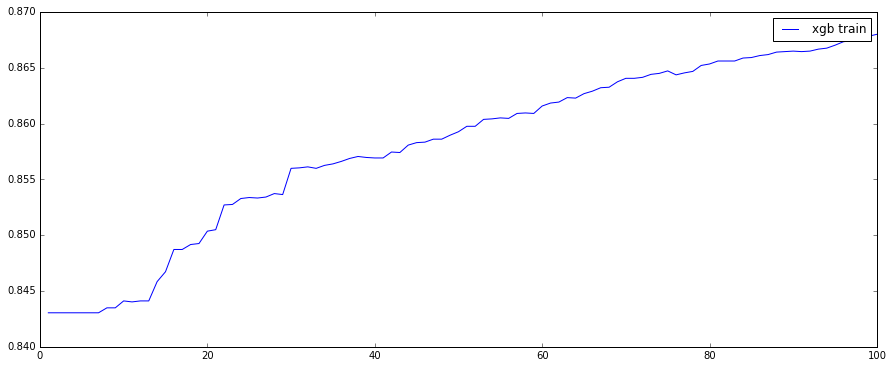

In [244]:
xgb_scores_train = xgboost_accuracy_scores(dtrain, y_train)

plt.figure(figsize=(15, 6))
plt.plot(np.arange(len(xgb_scores_train)) + 1, xgb_scores_train, label='xgb train')
plt.legend()
plt.show()

In [245]:
important_f

{'f0': 62,
 'f1': 156,
 'f10': 32,
 'f102': 1208,
 'f103': 2424,
 'f104': 550,
 'f105': 1210,
 'f106': 882,
 'f107': 656,
 'f108': 484,
 'f109': 164,
 'f11': 90,
 'f110': 94,
 'f12': 80,
 'f13': 32,
 'f14': 4,
 'f15': 22,
 'f16': 10,
 'f17': 72,
 'f18': 6,
 'f19': 8,
 'f2': 124,
 'f20': 6,
 'f21': 8,
 'f22': 14,
 'f24': 2,
 'f25': 238,
 'f26': 48,
 'f27': 44,
 'f28': 36,
 'f29': 12,
 'f3': 74,
 'f30': 40,
 'f31': 70,
 'f32': 108,
 'f33': 116,
 'f34': 48,
 'f35': 66,
 'f36': 56,
 'f37': 74,
 'f38': 52,
 'f39': 72,
 'f4': 86,
 'f40': 94,
 'f41': 52,
 'f42': 34,
 'f43': 30,
 'f44': 70,
 'f45': 4,
 'f46': 42,
 'f47': 176,
 'f48': 42,
 'f49': 70,
 'f5': 2,
 'f50': 112,
 'f51': 42,
 'f52': 52,
 'f53': 44,
 'f54': 34,
 'f55': 34,
 'f56': 32,
 'f57': 32,
 'f58': 170,
 'f6': 58,
 'f60': 38,
 'f61': 10,
 'f62': 24,
 'f63': 46,
 'f64': 34,
 'f65': 62,
 'f66': 4,
 'f68': 22,
 'f69': 8,
 'f70': 30,
 'f71': 16,
 'f72': 32,
 'f73': 40,
 'f74': 30,
 'f75': 54,
 'f76': 54,
 'f77': 18,
 'f78': 30,
 'f79

In [246]:
print(important_f.keys())

dict_keys(['f58', 'f5', 'f102', 'f34', 'f81', 'f36', 'f105', 'f75', 'f40', 'f2', 'f92', 'f42', 'f85', 'f50', 'f31', 'f77', 'f38', 'f78', 'f32', 'f86', 'f3', 'f54', 'f10', 'f26', 'f53', 'f71', 'f19', 'f46', 'f68', 'f89', 'f57', 'f1', 'f70', 'f73', 'f48', 'f65', 'f80', 'f35', 'f37', 'f28', 'f13', 'f94', 'f6', 'f14', 'f9', 'f98', 'f33', 'f74', 'f45', 'f87', 'f82', 'f39', 'f84', 'f79', 'f16', 'f103', 'f63', 'f41', 'f27', 'f104', 'f72', 'f29', 'f95', 'f64', 'f11', 'f56', 'f60', 'f24', 'f22', 'f83', 'f12', 'f21', 'f61', 'f52', 'f15', 'f17', 'f20', 'f62', 'f109', 'f30', 'f76', 'f18', 'f99', 'f108', 'f44', 'f0', 'f107', 'f47', 'f43', 'f91', 'f25', 'f55', 'f4', 'f66', 'f49', 'f93', 'f106', 'f96', 'f51', 'f69', 'f110'])


In [252]:
fi = [0, 1, 102, 103, 104, 105, 106, 107, 108, 109, 11, 110, 12, 17, 2, 25, 3, 31, 32, 33, 35, 36, 37, 38, 39, 4,
      40, 41, 44, 47]

In [255]:
%%time
num_boost_round = 200
model = xgb.train(plst, dtrain, num_boost_round=num_boost_round)

CPU times: user 14.7 s, sys: 164 ms, total: 14.9 s
Wall time: 6.41 s


In [256]:
ans = model.predict(dtest, )

with open ('resultsV11', 'w') as f:
    f.write('id,target\n')
    for i in range(10000):
        f.write(str(22562 + i) + ',' + str(int(ans[i])) + '\n')

In [257]:
sum(ans)/len(ans)

0.1986